In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = [5, 4]
mpl.rcParams['figure.dpi'] = 150
from sklearn import datasets
from sklearn import linear_model

In [2]:
import tensorflow as tf

/Users/danielacuna/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/danielacuna/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
tf.__version__

'1.7.0'

# Many ways to run logistic regression with Tensforflow

A one layer neural network with sigmoidal activations is logistic regression. 

$$
y_i = \sigma(b x_i + \epsilon_i)
$$

where $\sigma ( z )$ is simply:

$$ \frac{1}{1+\exp(-z)} $$

In [4]:
def sigmoid(z):
    return 1./(1.+np.exp(-z))
z = np.arange(-3, 3, 0.01)

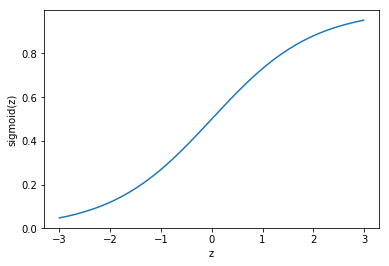

In [5]:
plt.plot(z, sigmoid(z));
plt.xlabel('z');
plt.ylabel('sigmoid(z)');

We will create a fake dataset with `scikit-learn`:

In [6]:
n_features = 2
X_data, y_data = datasets.make_classification(n_features=2, n_informative=2, n_redundant=0, random_state=2)

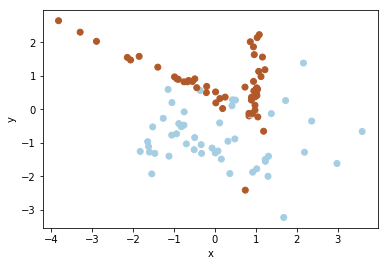

In [7]:
plt.scatter(X_data[:, 0], X_data[:, 1], c=y_data, cmap=plt.cm.Paired);
plt.xlabel('x');
plt.ylabel('y');

We create simbolic nodes that will hold the data; these nodes are known as placeholders in Tensorflow

In [8]:
try:
    sess.close()
except:
    pass
# tf.ops.reset_default_graph()

In [9]:
sess = tf.InteractiveSession()

In [10]:
sess

In [11]:
X = tf.placeholder(np.float32, shape = (None, n_features), name='X')
y = tf.placeholder(np.float32, shape = (None, 1), name = 'y')

Now we build the neural network

In [12]:
b0 = tf.Variable(tf.random_uniform((1,), minval=-1., maxval=1.), name='bias')
b = tf.Variable(tf.random_uniform((n_features, 1), minval=-1., maxval=1.), name='effects')

In [13]:
with tf.name_scope('log_likelihood'):
    z = b0 + tf.matmul(X, b)
    y_hat = tf.nn.sigmoid(z)
    log_likelihood = y*tf.log(y_hat) + (1-y)*tf.log(1-y_hat)
#     squared_error = (y - y_hat)**2

In [14]:
with tf.name_scope('cost_nll'):
    cost = -tf.reduce_sum(log_likelihood)

In [15]:
tf.global_variables_initializer().run()

In [16]:
sess.run(b0)

array([-0.5219796], dtype=float32)

In [17]:
sess.run(b)

array([[-0.56854606],
       [ 0.8792107 ]], dtype=float32)

In [18]:
with tf.name_scope('train'):
    optimizer = tf.train.AdagradOptimizer(0.01)
    train_op = optimizer.minimize(cost)

In [19]:
# Summaries for display purposes
w_hist = tf.summary.histogram("weights", b)
b_hist = tf.summary.histogram("biases", b0)
y_hist = tf.summary.histogram("y", y_hat)
cost_summ = tf.summary.scalar("negative_ll", cost)

In [20]:
merged_summ = tf.summary.merge_all()

In [21]:
tf.global_variables_initializer().run()

In [22]:
!rm -rf /tmp/logistic_regression2/

In [23]:
summary_writer = tf.summary.FileWriter('/tmp/logistic_regression2/', graph=sess.graph)

In [24]:
for i in range(200):
    idx = np.random.choice(range(X_data.shape[0]), size=X_data.shape[0], replace=False)
    X_data2 = X_data[idx]
    y2 = np.atleast_2d(y_data).T[idx]
    feed_dict={X: X_data2,
               y: y2}
    cost_t, _ = sess.run([cost, train_op],
                         feed_dict=feed_dict)
    if i % 5 == 0:
        summary_str = sess.run(merged_summ, feed_dict)
        summary_writer.add_summary(summary_str, i)
        print(i/5)

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0


In [25]:
sklearn_lr = linear_model.LogisticRegression(penalty='l2').fit(X_data, y_data)

In [26]:
sess.run([b0, b])

[array([-0.60560644], dtype=float32), array([[-0.4552018],
        [ 0.8319079]], dtype=float32)]

In [27]:
np.hstack((sklearn_lr.intercept_,sklearn_lr.coef_.flatten()))

array([1.52441200e-03, 2.73459311e-01, 2.01841490e+00])

In [28]:
np.vstack(sess.run([b0, b])).flatten()

array([-0.60560644, -0.4552018 ,  0.8319079 ], dtype=float32)

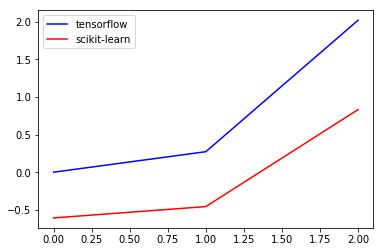

In [29]:
plt.figure()
p0 = plt.plot(np.hstack((sklearn_lr.intercept_,sklearn_lr.coef_.flatten())), 'b', label='tensorflow');
p1 = plt.plot(np.vstack(sess.run([b0, b])).flatten(), 'r', label='scikit-learn');
plt.legend();

In [30]:
(sklearn_lr.predict(X_data) == y_data).mean()

0.86

In [31]:
((sess.run(y_hat, feed_dict={X: X_data, y: np.atleast_2d(y_data).T}) > 0.5).astype(int).flatten() == y_data).mean()

0.69